### Imports

In [ ]:
!pip install essentia
!pip install mir_eval
!pip install pydub

In [ ]:
import essentia
import essentia.standard as es
import essentia.streaming as ess
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
from IPython.display import Audio, display, clear_output
from IPython import display as disp
from mir_eval.sonify import pitch_contour
from google.colab import output
import base64
from pydub import AudioSegment
from time import sleep
import io
import tempfile
import librosa
import IPython
%matplotlib inline
from pylab import plot, show, figure, imshow

### Audio processing

In [ ]:
def detect_bpm(audio_filename: str) -> float:
  """
  Returns detected tempo of the song.
  Takes the path to the audio file as an input.
  """
  sampling_rate = 44100
  audio = es.MonoLoader(filename=audio_filename, sampleRate=sampling_rate)()
  return detect_user_bpm(audio)

def detect_user_bpm(audio: list) -> float:
  """
  Returns detected tempo of the song.
  Takes the array of the loaded audio file as an input.
  """
  return es.PercivalBpmEstimator()(audio)
  

def extract_pitches(audio: str) -> tuple:
  """
  Calculates pitch attributes of the song.
  Parameters:
  - audio: a path to an audio file
  Returns:
  - pitch_times: list
  - pitch_values: list
  - pitch_confidence: list
  """
  audio = es.EqloudLoader(filename=audio, sampleRate=44100)()
  return extract_user_pitches(audio)


def extract_user_pitches(audio) -> tuple:
  """
  Calculates pitch attributes of the song.
  Parameters:
  - audio: a list of values of an loaded audio file
  Returns:
  - pitch_times: list
  - pitch_values: list
  - pitch_confidence: list
  """
  pitch_extractor = es.PredominantPitchMelodia(frameSize=2048, hopSize=128)
  pitch_values, pitch_confidence = pitch_extractor(audio)

  pitch_times = np.linspace(0.0, len(audio)/44100, len(pitch_values))
  return pitch_times, pitch_values, pitch_confidence


def plot_pitch_curve(pitch_attributes) -> None:
  """
  Displays the plot of the detected pitch along with its confidence.
  """
  pitch_times, pitch_values, pitch_confidence = pitch_attributes
  f, axarr = plt.subplots(2, sharex=True)
  axarr[0].plot(pitch_times, pitch_values)
  axarr[0].set_title('estimated pitch [Hz]')
  axarr[1].plot(pitch_times, pitch_confidence)
  axarr[1].set_title('pitch confidence')
  plt.show()


def compose_determined_pitch(pitch_times, pitch_values):
  """
  Compose and play the detected pitch values.
  """
  synthesized_melody = pitch_contour(pitch_times, pitch_values, 44100).astype(np.float32)
  es.AudioWriter(filename='test.mp3', format='mp3')(es.StereoMuxer()([0 for _ in range(len(synthesized_melody))], synthesized_melody))
  display(Audio('test.mp3'))


In [ ]:
example = "carry_me_away.wav"
Audio(example)

tempo of the song: 139.67483520507812


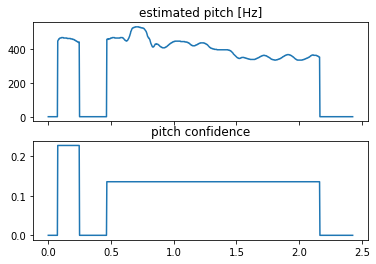

In [ ]:
print(f'tempo of the song: {detect_bpm(example)}')
pitch = extract_pitches(example)
plot_pitch_curve(pitch)
compose_determined_pitch(pitch[0], pitch[1])

### Onset detection and (Pitch, Rhythm) pair creation

Once the onsets are detected, we can form $<\text{Pitch}, \text{Rhythm}>$ pairs to be used in matching later. Each $\text{Rhythm}$ component is the $\log(\text{IOI})$, a logarithm of an inter-onset interval, while the corresponding $\text{Pitch}$ is the average value of pitches that have been detected and belong to that interval.

In [ ]:
from math import log2

def get_note_number(pitch: float) -> int:
  """
  Return the number of the note based on its frequency vale.
  """
  if pitch == 0:
    return 0
  n = 12 * log2(pitch/440) + 49
  if 1 <= n <= 88:
    return round(n)
  return 0

def pitches_per_interval(audio, pitch_values: list, onsets: list, sampling_rate=44100) -> list:
  """
  Calculate the number of pitches contained between two consecutive onsets.
  """
  num_of_pitches = []
  for oc in onsets:
    num_of_pitches.append(int(oc * len(pitch_values) / int(len(audio)/sampling_rate)))

  num_of_pitches.append(len(pitch_values))
  
  return num_of_pitches


def average_per_interval(pitch_values: list, pitches_per_interval: list, onsets: list) -> list:
  """
  Calculate the average of pitches contained between two consecutive onsets
  and convert the note value to a number.
  """
  avg_per_interval = []
  for i in range(len(onsets) - 1):
    avg_pitch = sum(pitch_values[pitches_per_interval[i]:pitches_per_interval[i+1]])/(pitches_per_interval[i+1]-pitches_per_interval[i])
    avg_per_interval.append(get_note_number(avg_pitch))

  return avg_per_interval


def log_ioi(onsets: list, duration) -> list:
  """
  Calculate log(IOI), the logarithm of time between the two adjacent onsets.
  For the last note, its duration is taken as its IOI.
  """
  log_ioi = []
  for i in range(len(onsets) - 1):
    log_ioi.append(round(np.log(onsets[i+1] - onsets[i])))
  log_ioi.append(duration - onsets[i])
  
  return log_ioi


def create_pitch_rhythm_pairs(avg_pitch_values: list, log_ioi_values: list) -> list:
  """
  Create and return an array of <pitch, rhythm> pairs.
  """
  return [el for el in zip(avg_pitch_values, log_ioi_values)]


def find_relative_pitch(avg_pitch_values: list) -> list:
  """
  Create and return an array of relative <pitch, rhythm> pairs.
  """
  pitch_change = 0
  result = []
  for i in range(len(avg_pitch_values) - 1):
    pitch_change = -1 * (avg_pitch_values[i] - avg_pitch_values[i + 1])
    if pitch_change == 0 or abs(pitch_change) >= 22:
      continue
    result.append(pitch_change)
  return result

In [ ]:
def detect_complex_onsets(audio) -> list:
  """
  This function detects onsets of an audio using complex method and returns it as a list.
  """
  od = es.OnsetDetection(method='complex')

  # Let's also get the other algorithms we will need, and a pool to store the results
  w = es.Windowing(type = 'hann')
  fft = es.FFT() # this gives us a complex FFT
  c2p = es.CartesianToPolar() # and this turns it into a pair (magnitude, phase)
  pool = essentia.Pool()

  # Computing onset detection functions.
  for frame in es.FrameGenerator(audio, frameSize = 1024, hopSize = 512):
      mag, phase, = c2p(fft(w(frame)))
      pool.add('features.complex', od(mag, phase))

# Compute the actual onsets locations
  onsets = es.Onsets()

  onsets_complex = onsets(essentia.array([ pool['features.complex'] ]), [ 1 ])

  return onsets_complex

### Real-time recording

In [ ]:
def record_audio(seconds=3,
                 sample_rate=44100,
                 normalize_db=0.1):
    """
    Record audio from the browser in colab using javascript.
    Based on: https://gist.github.com/korakot/c21c3476c024ad6d56d5f48b0bca92be
    Args:
      seconds: Number of seconds to record.
      sample_rate: Resample recorded audio to this sample rate.
      normalize_db: Normalize the audio to this many decibels. Set to None to skip
        normalization step.
    Returns:
      An array of the recorded audio at sample_rate.
    """
    # Use Javascript to record audio.
    record_js_code = """
      const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
      const b2text = blob => new Promise(resolve => {
        const reader = new FileReader()
        reader.onloadend = e => resolve(e.srcElement.result)
        reader.readAsDataURL(blob)
      })
      var record = time => new Promise(async resolve => {
        stream = await navigator.mediaDevices.getUserMedia({ audio: true })
        recorder = new MediaRecorder(stream)
        chunks = []
        recorder.ondataavailable = e => chunks.push(e.data)
        recorder.start()
        await sleep(time)
        recorder.onstop = async ()=>{
          blob = new Blob(chunks)
          text = await b2text(blob)
          resolve(text)
        }
        recorder.stop()
      })
      """
    print('Starting recording for {} seconds...'.format(seconds))
    display(disp.Javascript(record_js_code))
    audio_string = output.eval_js('record(%d)' % (seconds * 1000.0))
    print('Finished recording!')
    audio_bytes = base64.b64decode(audio_string.split(',')[1])
    return audio_bytes_to_np(audio_bytes,
                             sample_rate=sample_rate,
                             normalize_db=normalize_db)
    
def audio_bytes_to_np(wav_data,
                      sample_rate=44100,
                      normalize_db=0.1):
    """
    Convert audio file data (in bytes) into a numpy array.
    Saves to a tempfile and loads with librosa.
    Args:
      wav_data: A byte stream of audio data.
      sample_rate: Resample recorded audio to this sample rate.
      normalize_db: Normalize the audio to this many decibels. Set to None to skip
        normalization step.
    Returns:
      An array of the recorded audio at sample_rate.
    """
    # Parse and normalize the audio.
    audio = AudioSegment.from_file(io.BytesIO(wav_data))
    audio.remove_dc_offset()
    if normalize_db is not None:
        audio.normalize(headroom=normalize_db)
    # Save to tempfile and load with librosa.
    with tempfile.NamedTemporaryFile(suffix='.wav') as temp_wav_file:
        fname = temp_wav_file.name
        audio.export(fname, format='wav')
        audio_np, unused_sr = librosa.load(fname, sr=sample_rate)
    return audio_np

## Matching

In [ ]:
def find_max_cross_correlation(song: list, input: list) -> int:
  """
  Calculates and returns the maximum cross corelation value
  of the given two lists.
  """
  return np.max(np.correlate(song, input, 'full'))


def calculate_min_distance(song_pitches: list, user_pitches: list) -> int:
  """
  Calculates and returns the minimum Hamming distance between user input and
  all corresponding song intervals.
  """
  max_corr = 0
  for i in range(len(user_pitches), len(song_pitches) + 1):
    max_corr = max(find_max_cross_correlation(song_pitches[i - len(user_pitches):i], user_pitches), max_corr)
  return max_corr

In [ ]:
def match_song(database: list, user_input: list) -> str:
  """
  Finds three closest songs that match user input.
  Return the names of the matched songs.

  Database should consist of tuples with the following song info
  in the exact order: (<song name>, <song tempo>, <list of song's relative pitches>).
  User input should be the following: [<query tempo>, <query replative pitches>].
  """
  match = None
  min_distance = 0
  distances = []
  user_bpm, user_pitches = user_input
  for song in database:
    song_name, song_bpm, song_pitches = song
    if user_bpm > 2 * song_bpm or user_bpm < song_bpm / 2:
      continue
    distance = calculate_min_distance(song_pitches, user_pitches)
    distances.append((distance, song_name))
  distances.sort(reverse=True)
  return [name[1].split(".")[0] for name in distances[:3]]

## Database creation and editing

In [ ]:
def create_database(audio_filenames: list, sampling_rate = 44100) -> list:
  """
  Create a database consisting of all songs from the input list.
  The song in database contain infornation such as:
  - song name
  - song tempo
  - list of relative pitches
  """
  database = []
  for song_name in audio_filenames:
    audio = es.MonoLoader(filename=song_name, sampleRate=sampling_rate)()
    pitch_times, pitch_values, pitch_confidence = extract_pitches(song_name)
    onsets = detect_complex_onsets(audio)

    num_of_pitches = pitches_per_interval(audio, pitch_values, onsets, sampling_rate)
    avg = average_per_interval(pitch_values, num_of_pitches, onsets)
    ioi = log_ioi(onsets, len(audio)/sampling_rate)
    song_pitches = find_relative_pitch(avg)

    database.append((song_name, detect_bpm(song_name), song_pitches))
  return database


def add_songs(database: list, songs_to_add: list) -> None:
  """
  Add songs to a database inplace.
  Parameters:
  - database: list where the song will be added
  - songs_to_add: list of paths to the audio files that will be added
  """
  songs_with_all_info = create_database(songs_to_add)
  for new_song in songs_with_all_info:
    database.append(new_song)

def process_user_input(audio: list, sample_rate=44100) -> list:
  """
  Returns a list containing audio tempo and relative pitches.
  Display the determined composed pitches.
  """
  pitch_times, pitch_values, pitch_confidence = extract_user_pitches(audio)
  onsets = detect_complex_onsets(audio)
  compose_determined_pitch(pitch_times, pitch_values)

  num_of_pitches = pitches_per_interval(audio, pitch_values, onsets, sample_rate)
  avg = average_per_interval(pitch_values, num_of_pitches, onsets)
  ioi = log_ioi(onsets, len(audio)/sample_rate)

  user_pitches = find_relative_pitch(avg)
  return [detect_user_bpm(audio), user_pitches]

## Testing

In [ ]:
# create song database
song_names = ["Tep No - Fighting.mp3", "Amy Macdonald - This is The Life.mp3",
              "Avicii - The Nights.mp3", "Avicii - Wake Me Up.mp3",
              "Ed Sheeran - Shape Of You.mp3", "Stefania.mp3",
              "Meiko - Leave The Lights On.mp3", "Nathan Goshen - Thinking About It.mp3",
              "Rag'n'Bone Man - Human.mp3", "Rag'n'Bone Man - Lay My Body Down.mp3", "SHAED, Zayn - Trampoline.mp3" ]
db = create_database(song_names)

#### Real-time input

In [ ]:
#@title Record
#@markdown Set recording time:

SAMPLE_RATE = 44100
record_seconds =   8#@param {type:"number", min:1, max:15, step:1}

def _record_audio(b):
  global audio
  clear_output()
  audio = record_audio(record_seconds, sample_rate=SAMPLE_RATE)
  display(Audio(audio, rate=SAMPLE_RATE))

button = widgets.Button(description="Start recording...")
button.on_click(_record_audio)
display(button)

Starting recording for 8 seconds...


<IPython.core.display.Javascript object>

Finished recording!


In [ ]:
user_input = process_user_input(audio)

In [ ]:
match = match_song(db, user_input)
print("Your song is among the following ones:\n")

print(match[0])
Audio(match[0] + ".mp3")

Your song is among the following ones:

Stefania


In [ ]:
print(match[1])
Audio(match[1] + ".mp3")

In [ ]:
print(match[2])
Audio(match[2] + ".mp3")